### This jupyter notebook is based on the results from Cornelius Hempel et. al. "Quantum chemistry calculations on a trapped-ion quantum simulator" (2018) arXiv 1803.10238. The goal is to determine the ground energy for $R=0.5$ Å between two H atoms. <img src="H2_300dpi.png" width="200">

In [2]:
# Basics
from numpy import pi
import numpy as np
import matplotlib.pyplot as plt
import scipy
%matplotlib inline

# OpenFermion for quantum chemistry
try:
    import openfermion
except:
    import os
    os.chdir('/home/alexgo/libs/OpenFermion/src/')
    import openfermion

# ProjectQ for simulating quantum circuits
import projectq

# Preprocessing
## linear combination of atomic orbitals (LCAO)
#### Determine basis to represent wavefunction of each atom. One approach is to approximate the time independent initial state with Slater type orbitals (STOs)

#### $S_{nlm}^{\zeta}(\vartheta,\varphi)= Nr^{n-1}e^{-\zeta r}Y_l^m(\vartheta,\varphi)$ 
$N$ is a normalization constant

$r$ radius

$n$ is the prinicipal quantum number

$\zeta$ the slater exponent, determined by the effective charge

$Y_l^m(\vartheta, \varphi)$ spherical harmonic describing the position in the orbital space

#### For the sake of easier computation these orbitals are approximated with Gaussian type orbitals (GTOs)
#### $CGF_{nlm}^{\alpha}(\vartheta,\varphi)= N\sum_{i=1}^k c_i r^{n-1}e^{-\alpha r^2}Y_l^m(\vartheta,\varphi)$ 

#### For the hydrogen atom this can be simplified STG-1G

#### $S_{\textrm{1s}}^{\zeta}(r) = (\zeta^3/\pi)^{1/2}e^{-\zeta r}$

#### $GF_{\textrm{1s}}^{\alpha}(r) = (2\alpha/\pi)^{3/4}e^{-\alpha r^2}$

# $\emptyset$


In [19]:
# For hydrogen the spherical harmonic can be ignored and n = 1
def slater_type_orbital(zeta,r):
    return np.sqrt(zeta**3/np.pi)*np.exp(-np.abs(zeta*r))
def gaussian_type_orbital(alpha,r):
    return (2*alpha/np.pi)**(3/4)*np.exp(-alpha*r**2)

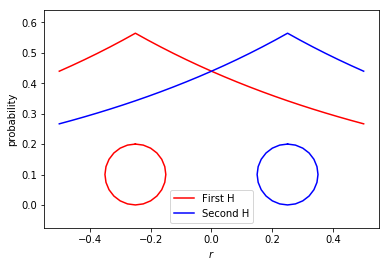

In [36]:
# Solution obtained from "Modern quantum chemistry"
x = np.linspace(-0.5,0.5,25)
vartheta = np.linspace(0,2*np.pi,25)
plt.plot(x,slater_type_orbital(1,x+0.25),'r-',label='First H ')
plt.plot(x,slater_type_orbital(1,x-0.25),'b-',label='Second H')
plt.plot(0.1*np.sin(vartheta)-0.25, 0.1*np.cos(vartheta)+0.1, 'r')
plt.plot(0.1*np.sin(vartheta)+0.25, 0.1*np.cos(vartheta)+0.1, 'b')
plt.ylabel('probability')
plt.xlabel('$r$')
plt.legend()
plt.axis('equal')
plt.show()

### Least-squares fit $\min_\alpha \int dr \,[S_{\textrm{1s}}^{1}(r)- GF_{\textrm{1s}}^{\alpha}(r))]^2$
#### Solutions obtained from "Modern quantum chemistry"

In [4]:
basis = 'sto-3g' # it uses 3 Gaussian functions (3G) to approximate one Slater-type orbitals (STO).
multiplicity = 1 # spin multiplicity = 2S + 1

## Configuration
#### Load $\textrm{H}_2$ molecule data for bond length $R=0.5$ Å with OpenFermion

#### The Molecular Hamiltonian described in the second-quantized formulation is 

### $H_2 = \sum_{pq}h_{pq}a_p^{\dagger}a_q + \frac12 \sum_{pqrs}h_{pqrs}a_p^{\dagger}a_q^{\dagger}a_ra_s$ 
#### with the coefficients
### $h_{pq} = \int d\sigma \phi_p^{*}(\sigma)\bigg(\frac{\nabla^2}2 -\sum_i \frac{Z_i}{|R_i-r|}\bigg)\phi_q^{*}(\sigma)$, nucleus electron interaction
### $h_{pqrs} = \int d\sigma \frac{\phi_p^{*}(\sigma_1)\phi_q^{*}(\sigma_2)\phi_s(\sigma_1)\phi_r(\sigma_2)}{|r_1-r_2|}$ electron electron interaction

$\sigma_i =(r_i,s_i)$ describes the electron's spatial and spin coordinates

$\phi_p^{*}$ describes the adjoint of the wave function



In [5]:
bond_length = 0.5
description = str(round(bond_length,2))
print("Testing theta terms for bond length", bond_length)
geometry = [('H', (0., 0., 0.)), ('H', (0., 0., bond_length))] 
molecule = openfermion.hamiltonians.MolecularData(
    geometry, basis, multiplicity, description=description)
molecule.load()
print('Precalculated Integrals ')

Testing theta terms for bond length 0.5


## Bravyi Kitaev transformation $c(R)$.

In [5]:
print('Bravyi-Kitaev Transformation as in (B1)')
h2_molecule_hamiltonian = molecule.get_molecular_hamiltonian()
h2_qubit_hamiltonian_bk = openfermion.transforms.bravyi_kitaev(openfermion.transforms.get_fermion_operator(h2_molecule_hamiltonian))
print(h2_qubit_hamiltonian_bk)

Bravyi-Kitaev Transformation as in (B1)
(0.37983134528089835+0j) [] +
(0.042217556947907534+0j) [X0 Z1 X2] +
(0.042217556947907534+0j) [X0 Z1 X2 Z3] +
(0.042217556947907534+0j) [Y0 Z1 Y2] +
(0.042217556947907534+0j) [Y0 Z1 Y2 Z3] +
(0.21393530980032915+0j) [Z0] +
(0.2139353098003293+0j) [Z0 Z1] +
(0.17680996028469176+0j) [Z0 Z1 Z2] +
(0.17680996028469176+0j) [Z0 Z1 Z2 Z3] +
(0.13459240333678427+0j) [Z0 Z2] +
(0.13459240333678427+0j) [Z0 Z2 Z3] +
(0.17992650966559584+0j) [Z1] +
(-0.3691443135445023+0j) [Z1 Z2 Z3] +
(0.18620984247889977+0j) [Z1 Z3] +
(-0.3691443135445023+0j) [Z2]


### Process coeffcients for molecule configuration $c(R)$. In this case on the first and third basis only Z measurements are applied. Since they do only result in zero states for the initial state, we can ignore them. 

In [6]:
print('On the qubits 1 and 3 only the identity and σ_z operations are applied.')
print('X1 operations:',str(h2_qubit_hamiltonian_bk).count('X1'))
print('Y1 operations:',str(h2_qubit_hamiltonian_bk).count('Y1'))
print('X1 operations:',str(h2_qubit_hamiltonian_bk).count('X1'))
print('X3 operations:',str(h2_qubit_hamiltonian_bk).count('X3'))
print('Y3 operations:',str(h2_qubit_hamiltonian_bk).count('Y3'))
print()
print('Therefore we can ommit them and use:')
print(str(h2_qubit_hamiltonian_bk).replace('Z1 ','').replace(' Z1','').replace('Z1','').replace('Z3 ','').replace(' Z3','').replace('Z3',''))

# Perprare coeffcients of basis set for later evaluation in the VQE process
def sum_up_basis_set_of_h2_bk(h2_qubit_hamiltonian_bk):
    # mapping from 0 -> 0 and 2 -> 1
    config = {'Id':0,'Z0':0,'Z1':0,'Z0Z1':0,'X0X1':0,'Y0Y1':0}
    for basis, cvalue in h2_qubit_hamiltonian_bk.terms.items():
        if (0, 'Z') in basis and (2, 'Z') in basis:
            config['Z0Z1'] = config['Z0Z1'] + cvalue
        elif (0, 'Z') in basis:        
            config['Z0'] = config['Z0'] + cvalue
        elif (2, 'Z') in basis:
            config['Z1'] = config['Z1'] + cvalue
        elif (0, 'X') in basis and (2, 'X') in basis:
            config['X0X1'] = config['X0X1'] + cvalue
        elif (0, 'Y') in basis and (2, 'Y') in basis:
            config['Y0Y1'] = config['Y0Y1'] + cvalue
        else:
            config['Id'] = config['Id'] + cvalue
    return config

molecule_config = sum_up_basis_set_of_h2_bk(h2_qubit_hamiltonian_bk)

On the qubits 1 and 3 only the identity and σ_z operations are applied.
X1 operations: 0
Y1 operations: 0
X1 operations: 0
X3 operations: 0
Y3 operations: 0

Therefore we can ommit them and use:
(0.37983134528089835+0j) [] +
(0.042217556947907534+0j) [X0 X2] +
(0.042217556947907534+0j) [X0 X2] +
(0.042217556947907534+0j) [Y0 Y2] +
(0.042217556947907534+0j) [Y0 Y2] +
(0.21393530980032915+0j) [Z0] +
(0.2139353098003293+0j) [Z0] +
(0.17680996028469176+0j) [Z0 Z2] +
(0.17680996028469176+0j) [Z0 Z2] +
(0.13459240333678427+0j) [Z0 Z2] +
(0.13459240333678427+0j) [Z0 Z2] +
(0.17992650966559584+0j) [] +
(-0.3691443135445023+0j) [Z2] +
(0.18620984247889977+0j) [] +
(-0.3691443135445023+0j) [Z2]


# VQE process
## Quantum part
### Simulates the circuit for the unitary $\exp(-i\theta\sigma_x(q0)\sigma_y(q1))$ (B3) paper
<img src="paper_circuit.png" width="400"> <img src="simulation_circuit_v1.png" width="500">

In [7]:
def h2_bk_circuit(q0, q1, eng, theta, measurement_basis):
    # The \ket{q0q1} with initial state \ket{00}
    projectq.ops.X | q0
    
    projectq.ops.Rx(pi/2) | q0
    projectq.ops.H | q1
    projectq.ops.CNOT | (q0, q1)
    projectq.ops.Rz(-(theta+pi)) | q1
    projectq.ops.CNOT | (q0, q1)
    projectq.ops.Rx(-pi/2) | q0
    projectq.ops.H | q1

    if measurement_basis == 'Z0Z1':
        projectq.ops.CNOT | (q0, q1)
    elif measurement_basis == 'X0X1':
        projectq.ops.H | q0
        projectq.ops.H | q1
        projectq.ops.CNOT | (q0, q1)
    elif measurement_basis == 'Y0Y1':
        projectq.ops.Sdag | q0
        projectq.ops.Sdag | q1
        projectq.ops.H | q0
        projectq.ops.H | q1
        projectq.ops.CNOT | (q0, q1)
        
    eng.flush()
    return [q0,q1]

## Classical part

In [8]:
# Prepares the run of the simulated quantum circuit and postprocesses measurement outcomes
def run_h2_bk_circuit(theta, measurement_basis='Z0/Z1'):
    eng = projectq.MainEngine(backend=projectq.backends.Simulator(gate_fusion=True), engine_list=[])    
    q1 = eng.allocate_qubit() # q1 and q0 are related to the paper
    q0 = eng.allocate_qubit()
    h2_bk_circuit(q0, q1, eng, theta, measurement_basis)
    projectq.ops.Measure | q0
    projectq.ops.Measure | q1
    eng.flush()    
    
    # result = \ket{q0q1}
    # result is mapped as follows: 0 ->1, 1 ->-1
    q0_result = -1 if int(q0) else 1
    q1_result = -1 if int(q1) else 1
    return [q0_result,q1_result]

# Combines the expected values of 
def estimate_eigenvalue(theta, config, number_of_runs=100, verbose=False):
    if verbose:
        print('theta',theta)
    z0, z1, z0z1, x0x1, y0y1 = estimate_expected_values(theta, number_of_runs)
    eigenvalue_estimation = config['Id']+config['Z0']*z0 + config['Z1']*z1 + config['Z0Z1']*z0z1 + config['X0X1']*x0x1 + config['Y0Y1']*y0y1
    if verbose:
        print('Estimated Eigval',eigenvalue_estimation)
    return np.real(eigenvalue_estimation)

# Estimates expected value from measurement outcomes from a simulated circuit
def estimate_expected_values(theta, number_of_runs, mean_tol=None):
    # Z0,Z1
    z0_outcomes = []
    z1_outcomes = []
    for i in range(number_of_runs):
        result = run_h2_bk_circuit(theta)
        z0_outcomes.append(result[0])
        z1_outcomes.append(result[1])
    z0 = np.mean(z0_outcomes)
    z1 = np.mean(z1_outcomes)
    # Z0Z1
    z0z1_outcomes = []
    for i in range(number_of_runs):
        z0z1_outcomes.append(run_h2_bk_circuit(theta,'Z0Z1')[1])
    z0z1 = np.mean(z0z1_outcomes)
    # X0X1
    x0x1_outcomes = []
    for i in range(number_of_runs):
        x0x1_outcomes.append(run_h2_bk_circuit(theta,'X0X1')[1])
    x0x1 = np.mean(x0x1_outcomes)
    # Y0Y1
    y0y1_outcomes = []
    
    for i in range(number_of_runs):
        y0y1_outcomes.append(run_h2_bk_circuit(theta,'Y0Y1')[1])
    y0y1 = np.mean(y0y1_outcomes)

    return z0,z1,z0z1,x0x1,y0y1

### This is for verification purposes. It runs the circuit on all possible parameters. Usually the parameter is sampled like we see it in the next step

env: OMP_NUM_THREADS=2
env: OMP_PROC_BIND=spread
theta 0.0
Estimated Eigval (1.2876335145941888+0j)
theta 0.1282282715750936


Exception ignored in: <bound method Qubit.__del__ of <projectq.types._qubit.Qubit object at 0x7f983fcf52e8>>
Traceback (most recent call last):
  File "/home/alexgo/.local/lib/python3.6/site-packages/projectq/types/_qubit.py", line 129, in __del__
    self.engine.deallocate_qubit(weak_copy)
  File "/home/alexgo/.local/lib/python3.6/site-packages/projectq/cengines/_basics.py", line 153, in deallocate_qubit
    tags=[DirtyQubitTag()] if is_dirty else [])])
  File "/home/alexgo/.local/lib/python3.6/site-packages/projectq/cengines/_basics.py", line 186, in send
    self.next_engine.receive(command_list)
  File "/home/alexgo/.local/lib/python3.6/site-packages/projectq/cengines/_tagremover.py", line 58, in receive
    self.send([cmd])
  File "/home/alexgo/.local/lib/python3.6/site-packages/projectq/cengines/_basics.py", line 186, in send
    self.next_engine.receive(command_list)
  File "/home/alexgo/.local/lib/python3.6/site-packages/projectq/cengines/_optimize.py", line 239, in receive
   

Estimated Eigval (1.284256110038356+0j)
theta 0.2564565431501872
Estimated Eigval (1.1886373741111966+0j)
theta 0.38468481472528077
Estimated Eigval (1.1551819755099058+0j)
theta 0.5129130863003744
Estimated Eigval (1.118349172352782+0j)
theta 0.6411413578754679
Estimated Eigval (1.0233677303396926+0j)
theta 0.7693696294505615
Estimated Eigval (0.8946122427682774+0j)
theta 0.8975979010256552
Estimated Eigval (0.6728826624187237+0j)
theta 1.0258261726007487
Estimated Eigval (0.5843373825602648+0j)
theta 1.1540544441758422
Estimated Eigval (0.4893559405471755+0j)
theta 1.2822827157509358
Estimated Eigval (0.36429650448862777+0j)
theta 1.4105109873260295
Estimated Eigval (-0.13224518823269604+0j)
theta 1.538739258901123
Estimated Eigval (0.024262297192191584+0j)
theta 1.6669675304762166
Estimated Eigval (-0.2322927370795343+0j)
theta 1.7951958020513104
Estimated Eigval (-0.4871590690733437+0j)
theta 1.9234240736264039
Estimated Eigval (-0.28875267365758367+0j)
theta 2.0516523452014974
Est

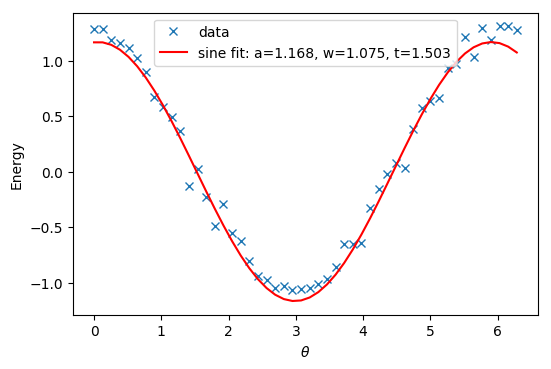

In [19]:
%set_env OMP_NUM_THREADS=2
%set_env OMP_PROC_BIND=spread

thetas = np.linspace(0,2*pi, 50)
eigvals = []
for theta in thetas:
    eigvals.append(estimate_eigenvalue(theta, molecule_config, 100, True))
    
def sin_fit(x,a,w,t):
    return a*np.sin(w*x+t)
popt, pcov = scipy.optimize.curve_fit(sin_fit, thetas, eigvals)
plt.figure(0, dpi=100)
plt.plot(thetas, eigvals, 'x', label='data')
plt.plot(thetas, sin_fit(thetas, *popt), 'r-',  label='sine fit: a=%5.3f, w=%5.3f, t=%5.3f' % tuple(popt))
plt.xlabel("$\\theta$")
plt.ylabel("Energy")
plt.legend()
plt.show()

### Run VQE with Nelder-Mead optimization and 1000 repetition to estimate expected value. In the plot you can see what parameters have been tested on the fitted sine curve of all values

env: OMP_NUM_THREADS=2
env: OMP_PROC_BIND=spread


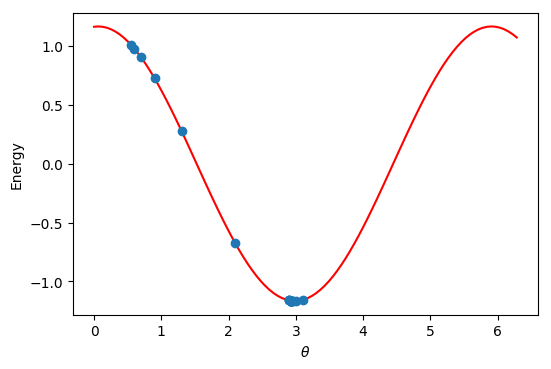

In [15]:
%set_env OMP_NUM_THREADS=2
%set_env OMP_PROC_BIND=spread

def sin_fit(x,a,w,t):
    return a*np.sin(w*x+t)
popt = [1.16760158, 1.07510618, 1.50277957]

# Fitted curve
# starting parameter 0.5
theta0 = np.array([0.5])
searched_parameters = []
def record_steps(theta):
    print('Appended',theta)
    searched_parameters.append(theta[0])
    
res = scipy.optimize.minimize(estimate_eigenvalue, theta0, args=(molecule_config, 1000, True), method='nelder-mead', options={'xtol': 1e-4, 'disp': True}, callback=record_steps)

plt.figure(0, dpi=100)
mi = np.min(searched_parameters)
ma = np.max(searched_parameters)
x = np.linspace(min(mi,0),max(ma,2*pi),100)
plt.plot(x, sin_fit(x, popt[0], popt[1], popt[2]), 'r-')
plt.plot(searched_parameters, sin_fit(np.array(searched_parameters), popt[0], popt[1], popt[2]), 'o')
plt.ylabel('Energy')
plt.xlabel('$\\theta$')
plt.savefig('1000_simulation_runs.pdf')
plt.show()